<h1 style="text-align: center;">Deep Learning Image Classification with CNN<br><br>Cat-Dog Classification Project<br><h1>

# Dataset Info

The Dogs vs. Cats dataset is a common computer vision dataset in which pictures are classified as either including a dog or a cat.

After the dataset is well studied, it can be used to understand and practice how to design, evaluate, and apply convolutional neural networks for image classification.

You will build a classifier with images and try to detect dogs versus cats using CNN.

Train set includes 12500 cat-5026 dog images, validation set includes 1219 cat-1071 dog images and test set includes 6897 cat and dogs images together. 

- https://www.kaggle.com/c/dogs-vs-cats/data
- https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/

# Import Libraries and Export Images from Zip_File

## colab Package Update

⚠️ **need to restart**

- https://github.com/tensorflow/addons#python-op-compatibility-matrix

In [1]:
# !pip install -Uq scikeras[tensorflow] # Causes tensorflow to update.
!pip install -Uq matplotlib matplotlib-dashboard seaborn scikit-plot tensorflow-addons==0.19.0  # tensorflow-addons -> colab-0.19.0, Kaggle-0.16.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 KB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 KB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.0/296.0 KB 24.7 MB/s eta 0:00:00


## Import Libraries

### Colab-only auth for this notebook and the TPU

In [1]:
import os
IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
if IS_COLAB_BACKEND:
    from google.colab import auth
    # Authenticates the Colab machine and also the TPU using your
    # credentials so that they can access your private GCS buckets.
    auth.authenticate_user()

In [2]:
# from google.colab import files
# uploaded = files.upload()

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

### TPU or GPU detection

In [4]:
import tensorflow as tf

print("Tensorflow version \t\t:" + tf.__version__)

# print("Available devices:")
# for i, device in enumerate(tf.config.list_logical_devices()):
#     print("%d) %s" % (i, device))

# check if tensorflow see the GPU
# tf.test.gpu_device_name()

print("Num physical_GPUs Available\t:", len(tf.config.list_physical_devices('GPU')))
print("Num physical_CPUs Available\t:", len(tf.config.list_physical_devices('CPU')))
print()
print("Num logical_GPUs Available\t:", len(tf.config.list_logical_devices('GPU')))
print("Num logical_CPUs Available\t:", len(tf.config.list_logical_devices('CPU')))

Tensorflow version 		:2.9.2
Num physical_GPUs Available	: 0
Num physical_CPUs Available	: 1

Num logical_GPUs Available	: 0
Num logical_CPUs Available	: 1


In [5]:
import tensorflow as tf

try:
    # resolver = tf.distribute.cluster_resolver.TPUClusterResolver() 
    # tf.config.experimental_connect_to_cluster(resolver)
    # tf.tpu.experimental.initialize_tpu_system(resolver)
    # strategy = tf.distribute.TPUStrategy(resolver)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)    
    print('Running on TPU ', tpu.master(), len(tf.config.list_logical_devices('TPU')))
    
except ValueError:
    # If there's a GPU avaiable, to use the GPU, otherwise, using the CPU instead.
    gpus = tf.config.list_logical_devices('GPU')
    if len(gpus) > 1:        
        strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])           
        print('Running on multiple GPUs ', gpus)  
    elif len(gpus) == 1:
        strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
        print('Running on single GPU ', gpus[0].name)
    else:
        strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
        print('Running on CPU')
        
print("Number of accelerators: ", strategy.num_replicas_in_sync)    
# tf.config.set_soft_device_placement(True)
# tf.debugging.set_log_device_placement(True)

Running on CPU
Number of accelerators:  1


In [6]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (10,6)
# The style parameters control properties like the color of the background and whether a grid is enabled by default.
# sns.set_style("whitegrid")
sns.set_style("whitegrid", {'axes.grid' : False})

# Environment settings: 
pd.set_option('display.float_format', lambda x: '%.4f' % x)
# pd.set_option('display.float_format', lambda x: f'{x:.3f}')
# pd.options.display.float_format = '{:.4f}'.format
# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)
# Set it None to display all rows in the dataframe
pd.set_option('display.max_rows', 100)

In [7]:
# import logging
# logging.warning('this will not show!')
# logging.basicConfig()  # configures the root logger
# logging.captureWarnings(True)
# logging.getLogger("py.warnings").setLevel(logging.WARNING)

# import warnings
# warnings.filterwarnings("ignore")
# warnings.filterwarnings("ignore", category=DeprecationWarning)
# warnings.warn("logged: this will not show")

# with warnings.catch_warnings():
#     warnings.warn('also logged')

# with warnings.catch_warnings(record=True) as warnings_caught:
#     warnings.warn('not logged')

# # show warnings recorded
# print([w.message for w in warnings_caught])

In [8]:
import re
import random
import pathlib

from glob import glob
from matplotlib.image import imread
import scipy.stats as stats

## Mixed Precision Policy

In [9]:
# float32 or mixed_float16 (mixed precision: compute float16, variable float32)
# TPU is fast enough and has enough memory to use float32
policy = tf.keras.mixed_precision.Policy('float32')
tf.keras.mixed_precision.set_global_policy(policy)

print(f'Compute dtype : {tf.keras.mixed_precision.global_policy().compute_dtype}')
print(f'Variable dtype: {tf.keras.mixed_precision.global_policy().variable_dtype}')

Compute dtype : float32
Variable dtype: float32


### Parameters

In [10]:
BATCH_SIZE = 128 * strategy.num_replicas_in_sync # Gobal batch size. # 64
# The global batch size will be automatically sharded across all
# replicas by the tf.data.Dataset API. A single TPU has 8 cores.
# The best practice is to scale the batch size by the number of
# replicas (cores). The learning rate should be increased as well.

LEARNING_RATE = 0.01
LEARNING_RATE_EXP_DECAY = 0.6 if strategy.num_replicas_in_sync == 1 else 0.7
# Learning rate computed later as LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch
# 0.7 decay instead of 0.6 means a slower decay, i.e. a faster learnign rate.

seed = random_state = 101

print(BATCH_SIZE)
print(round(LEARNING_RATE*LEARNING_RATE_EXP_DECAY, 3))

128
0.006


## Ingest Data from links below

In [11]:
# # https://github.com/wkentaro/gdown
!pip install gdown -Uq
import gdown

# Data Source
# url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'

# private Data Source
url = 'https://drive.google.com/u/0/uc?id=1tP_J6JW2CHroJPyFqSE2kgs3bRcVCy3h&export=download'
id  = '1tP_J6JW2CHroJPyFqSE2kgs3bRcVCy3h'

output = 'cat_dog_data.zip'                          # download local colab etc.
# output = '/content/drive/MyDrive/cat_dog_data.zip' # download drive
gdown.download(url=url, output=output, quiet=False)

!unzip -oq $output # unzip from $output to local

Downloading...
From: https://drive.google.com/u/0/uc?id=1tP_J6JW2CHroJPyFqSE2kgs3bRcVCy3h&export=download
To: /content/cat_dog_data.zip
100%|██████████| 595M/595M [00:02<00:00, 233MB/s]


In [12]:
# !unzip -oq /content/drive/MyDrive/yy-Data-Sources/cat_dog_data.zip

In [13]:
# Alternative method linux bash command
!sudo apt-get -qq install tree 
!tree -d ./data

./data
├── test
├── train
│   ├── cat
│   └── dog
└── validation
    ├── cat
    └── dog

7 directories


# Recognizing and Understanding Data

In [14]:
data_dir = "./data"

train_path = data_dir+'/train'
val_path   = data_dir+'/validation'
test_path  = data_dir+'/test'

print(train_path, val_path, test_path, sep='\n')

./data/train
./data/validation
./data/test


**Let's check how many images there are.**

In [15]:
from glob import glob

train_file_paths = glob(train_path + '/*/*.jpg')
total_train_file = len(train_file_paths)

val_file_paths   = glob(val_path + '/*/*.jpg')
total_val_file   = len(val_file_paths)

test_file_paths  = glob(test_path + '/*.jpg')
total_test_file   = len(test_file_paths)

print(f'Train size\t: {total_train_file:<10}')
print(f'Val size\t: {total_val_file:<10}')
print(f'Test size\t: {total_test_file:<10}')

Train size	: 17526     
Val size	: 2290      
Test size	: 6897      


# Data Preprocessing

## Define Parameters

**Let's decide on the final dimension of these images.**

In [16]:
CLASS_NAMES = np.unique(os.listdir(train_path))
CLASS_NAMES

array(['cat', 'dog'], dtype='<U3')

In [17]:
print(mpl.image.imread(train_file_paths[0]).shape)
IMAGE_SHAPE = (350, 400, 3)
IMAGE_SHAPE

(374, 500, 3)


(350, 400, 3)

## Check Scalling

**Let's check the images if they are needed to be scaled or not**

- https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/

In [18]:
mpl.image.imread(train_file_paths[0]).min(), mpl.image.imread(train_file_paths[0]).max()

(0, 255)

# Convolutional Neural Network Modeling

In [19]:
# !pip install tensorflow -Uq
import tensorflow as tf
# !pip install tensorflow-addons -Uq
import tensorflow_addons as tfa

from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer, LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score, roc_curve #, plot_roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import  SCORERS, precision_score, recall_score, f1_score, accuracy_score, cohen_kappa_score

# !pip install scikeras[tensorflow] -Uq  # Causes tensorflow to update.
# from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop, Nadam
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [20]:
# !pip install scikit-plot -Uq
import scikitplot as skplt

## Eval Metric Convolutional Neural Network

In [21]:
def plot_history(history, pipe=False):
    # Plot training results
    if pipe:
        H = history[-1].history.history
    else:
        H = history.history
    
    fig = plt.figure(figsize = (18, 7))

    plt.subplot(121)
    plt.plot(H['loss'], label = 'loss')
    plt.plot(H['val_loss'], label = 'val_loss')
    plt.grid()
    plt.legend()

    plt.subplot(122)
    plt.plot(H['recall'], label = 'recall')
    plt.plot(H['val_recall'], label = 'val_recall')
    plt.grid()
    plt.legend()

In [22]:
def plot_metrics(history, metrics_names, pipe=False):
    colors  = plt.rcParams['axes.prop_cycle'].by_key()['color']
    if pipe:
        history = history[-1].history
    else:
        history = history

    fig = plt.figure(figsize = (14, 10))

    for n, metric in enumerate(metrics_names):
        name = str(metric).replace("_"," ").capitalize()
        plt.subplot(3, 2, n+1)
        plt.plot(history.epoch, history.history[metric], 
                 color='xkcd:dodger blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color='salmon', ls="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name, fontsize=12)
        plt.legend()
        plt.tight_layout(pad=0.3)
        if metric == 'loss':
            plt.ylim(top=plt.ylim()[1])
        else: # plt.ylim(plt.gca().get_ylim())
            plt.ylim(bottom=plt.ylim()[0])

In [23]:
import IPython  
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

class TrainingAnimationCallback(tf.keras.callbacks.Callback):
    def __init__(self, duration = 40, fps = 1000/25):
        self.eps = np.finfo(np.float32).eps
        self.duration = duration
        self.fps = fps
        self.logs_history = []
        
    def on_train_batch_end(self, batch, logs=None):
        # logarithm_transform = lambda item: (item[0], np.log1p(item[1]))
        logarithm_transform = lambda item: (item[0], item[1])
        logs = dict(map(logarithm_transform, logs.items()))
        self.logs_history.append(logs)

    def set_plot(self):   
        self.figure = plt.figure()
        self.title = plt.title(f'batches:0')  
        self.plot = {}
        max_y = []
        for metric in self.model.metrics_names:
            self.plot[metric], = plt.plot([],[], label = metric)
            max_y.extend([max(np.ravel([log[metric]])) for log in self.logs_history])
        plt.xlabel('Epoch')
        plt.ylabel('Loss & Metrics ($Log_{1p}$ scale)')  
        plt.xticks(
            np.arange(0, self.params['steps']*self.params['epochs'], self.params['steps']),
            np.arange(0, self.params['epochs']))             
        # plt.xlim(0, len(self.logs_history)) 
        plt.ylim(0, max(max_y))          
        plt.legend(loc='upper right')
  
    def animation_function(self,frame):
        batch = frame % self.params['steps']
        self.title.set_text(f'batch:{batch}')                   
        for metric in self.model.metrics_names:
            y = np.array([log[metric] for log in self.logs_history[:frame]])
            if y.ndim>1:
                y = y[:, 1]
            x = np.arange(len(y))
            self.plot[metric].set_data(x, y)
       
    def on_train_end(self, logs=None):
        self.set_plot()
        interval    = 1000*(1/self.fps)
        num_frames  = int(self.duration*self.fps)
        num_batches = int(self.params['steps']*self.params['epochs'])
        selected_batches = range(0, num_batches , 1 if num_batches<num_frames else num_batches//num_frames)
        
        anim_created = FuncAnimation(fig=self.figure, 
                                     func=self.animation_function,
                                     fargs = None,
                                     frames=selected_batches,
                                     interval=interval,
                                     repeat = False)
        video = anim_created.to_html5_video()
        
        html = IPython.display.HTML(video)
        IPython.display.display(html)
        plt.close()

## Image Dataset from TFRecords, TFRecordWriter

**Image Manipulation**

We can use the ImageDataGenerator to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. ImageDataGenerator does the followings.

* Accepts a batch of images used for training.
* Applies a series of random transformations to each image in the batch.
* Replaces the original batch with randomly transformed batch.
* Training the CNN on this randomly transformed batch.

The goal of applying data augmentation is to have a more generalized model.

Data augmentation is a way to try and prevent a model overfitting. If your model is overfiting (e.g. the validation loss keeps increasing), you may want to try using data augmentation.

### Build TFRecords Dataset

Fundamentally, a `tf.train.Example` is a `{"string": tf.train.Feature}` mapping.

The `tf.train.Feature` message type can accept one of the following three types (See the [`.proto` file](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/example/feature.proto) for reference). Most other generic types can be coerced into one of these:

1. `tf.train.BytesList` (the following types can be coerced)

  - `string`
  - `byte`

1. `tf.train.FloatList` (the following types can be coerced)

  - `float` (`float32`)
  - `double` (`float64`)

1. `tf.train.Int64List` (the following types can be coerced)

  - `bool`
  - `enum`
  - `int32`
  - `uint32`
  - `int64`
  - `uint64`

In [24]:
def dataset_pipeline_TFRecord(
    data_dir             = data_dir,
    as_labeled:bool      = True,   
    as_data_augmentation = False,
    convert_TFRecord     = True,
    as_sample_weight     = False,  
):
    import os
    import cv2
    from glob import glob    
    AUTOTUNE            = tf.data.AUTOTUNE
    GCS_PATTERN         = {True: glob(data_dir + '/*/*.jpg'), False: glob(data_dir + '/*.jpg')}[as_labeled] 
    class_names         = np.unique(os.listdir(data_dir))  
    size                = IMAGE_SHAPE[:2]    
    
    def get_label(file_path):
        # Convert the path to a list of path components
        parts = tf.strings.split(file_path, os.path.sep)
        # The second to last is the class-directory
        one_hot = parts[-2] == class_names
        # Integer encode the label
        # label = tf.cast(one_hot, dtype=tf.int32)         # categorical
        label = tf.argmax(one_hot, output_type=tf.int64)   # binary
        return label 
    
    def process_path(file_path):
        file_path = file_path.numpy().decode("utf-8")
        # Load the raw data from the file as a string
        image = tf.io.read_file(filename=str(file_path))
        # Convert the compressed string to a 3D uint8 tensor
        image = tf.io.decode_image(contents=image, channels=3, expand_animations=False)
        if as_data_augmentation:
            # Data Augmentation preprocess_for_train -> tf.image.random_ or tf.image.stateless_random_ with seed
            # image = tf.image.stateless_random_crop(image, size=[*SIZE, 3], seed=(42, 101))
            image = tf.image.stateless_random_brightness(image, max_delta=0.02, seed=(42, 101))
            image = tf.image.stateless_random_contrast(image, lower=0.9, upper=1.2, seed=(42, 101))
            image = tf.image.stateless_random_flip_left_right(image, seed=(42, 101))
            image = tf.image.stateless_random_flip_up_down(image, seed=(42, 101))
            # image = tf.image.stateless_random_hue(image, max_delta=0.05, seed=(42, 101))
            image = tf.image.random_saturation(image, lower=0.95, upper=1.15)
        # Resize the image to the desired size [batch_size, height, width, color_channels]
        # image = tf.image.resize(image, size=SIZE)   
        image = cv2.resize(image.numpy(), size[::-1], interpolation=cv2.INTER_LINEAR)  # image resize    
        # Normalize Use `convert_image_dtype` to convert to floats in the [0,1] range.
        # image = (image - image.min()) / (image.max() - image.min())
        image = tf.image.convert_image_dtype(image, tf.float32)
        return {True: (image, get_label(file_path)), False: image}[as_labeled]      

    def batch_sample_weight(y):
        from sklearn.utils import class_weight
        sample_weight = class_weight.compute_sample_weight(class_weight='balanced', y=y)
        return sample_weight
    
    def _fixup_shape_label(image, label, size=None): 
        label.set_shape([]) # batch size
        return {True: [image, label, size], False: [image, label]}[convert_TFRecord]

    def recompress_image(image, label=""):
        # The bandwidth savings outweight the decoding CPU cost
        height = tf.shape(image)[0]
        width  = tf.shape(image)[1]
        size   = tf.convert_to_tensor([height, width], tf.int16)
        # image = tf.cast(image, tf.uint8)
        image = tf.image.convert_image_dtype(image, tf.uint8)
        image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)  # encode jpeg
        return {True: [image, label, size], False: [image, size]}[as_labeled]


    filenames    = GCS_PATTERN
    filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
    filenames_ds = filenames_ds.shuffle(len(filenames), reshuffle_each_iteration=False)
    
    # Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
    ds = filenames_ds.map(lambda x: 
                          tf.py_function(process_path, [x], {True: (tf.float32, tf.int64), False: tf.float32}[as_labeled])
                          , num_parallel_calls=AUTOTUNE)
           
    # if as_labeled and as_sample_weight:
        # ds = ds.map(lambda x, y: (x, y, tf.py_function(batch_sample_weight, [y], [tf.float32]) ))
        
    if convert_TFRecord:
        ds = ds.map(recompress_image, num_parallel_calls=AUTOTUNE)  # convert byte string for save
        
    if as_labeled:    
        ds = ds.map(_fixup_shape_label, num_parallel_calls=AUTOTUNE) 

    return ds

In [25]:
train_dataset  = dataset_pipeline_TFRecord(train_path, as_data_augmentation=True)
val_dataset    = dataset_pipeline_TFRecord(val_path)
test_dataset   = dataset_pipeline_TFRecord(test_path, as_labeled=False)

train_dataset, val_dataset, test_dataset

(<ParallelMapDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None), TensorSpec(shape=(2,), dtype=tf.int16, name=None))>,
 <ParallelMapDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None), TensorSpec(shape=(2,), dtype=tf.int16, name=None))>,
 <ParallelMapDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(2,), dtype=tf.int16, name=None))>)

In [26]:
for image, label, size in train_dataset.take(1):
    print("Image bytes: ", image)
    print("Label      : ", label)
    print("Size       : ", np.unique(size, axis=0))

Image bytes:  tf.Tensor(b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x01^\x01\x90\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1e\x00\x00\x01\x04\x02\x03\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x05\x04\x06\x07\x08\x03\t\x00\x02\n\x01\xff\xc4\x00N\x10\x00\x02\x01\x03\x03\x02\x04\x04\x04\x04\x04\x03\x05\x06\x01\r\x01\x02\x03\x04\x05\x11\x00\x06\x12\x07!\x08\x131A\t"Qa\x142q\x81\x15#\x91\xa1BRb\xb1\x163\xc1\n$r\xd1\xf0\x17%C\x82\x92\xa2\xe145Dcds\x83\xf1&6S\x93\xc2\xff\xc4\x00\x1b\x01\x00\x02\x03\x01\x01\x01\x00\x00\x00\x00\x00

In [27]:
for image, label, size in train_dataset.batch(16).take(1):
    print("Image shape: ", image.numpy().shape, "size: ", np.unique(size, axis=0))
    print("Label      : ", np.unique(label, return_counts=True))
    # print("Label      : ", np.unique(np.argmax(label, axis=1), return_counts=True))

Image shape:  (16,) size:  [[350 400]]
Label      :  (array([0, 1]), array([12,  4]))


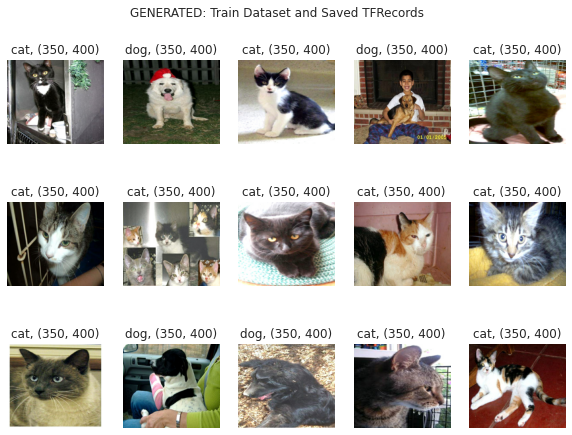

In [28]:
def show_tfrecord_batch(image_batch, label_batch=None, decode=False):
    """
    Check before saving permanently.
    """
    plt.figure(figsize=(10,10))
    for n in range(15):
        ax = plt.subplot(4, 5, n+1)        
        image = tf.io.decode_jpeg(image_batch[n], channels=3) if decode else image_batch[n]
        plt.imshow(image)
        if label_batch is None:
            plt.title(f"test")
        else:                       
            plt.title(f"{CLASS_NAMES[label_batch[n]]}, {image.shape[:2]}")
        plt.axis('off')

image_batch, label_batch, size = next(iter(train_dataset.batch(16).take(1)))
show_tfrecord_batch(image_batch.numpy(), label_batch.numpy(), decode=True)
plt.suptitle("GENERATED: Train Dataset and Saved TFRecords", y=.93);

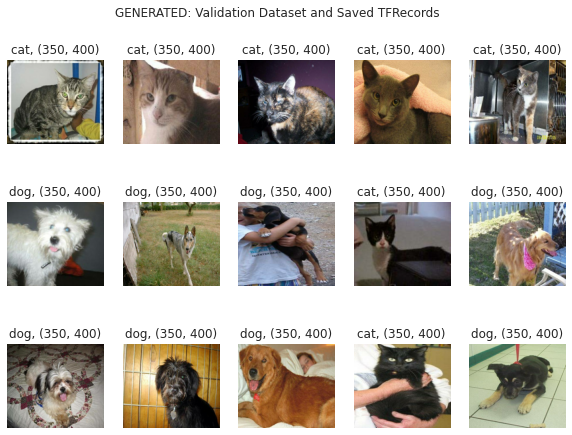

In [29]:
image_batch, label_batch, *_ = next(iter(val_dataset.batch(16).take(1)))
show_tfrecord_batch(image_batch.numpy(), label_batch.numpy(), decode=True)
plt.suptitle("GENERATED: Validation Dataset and Saved TFRecords", y=.93);

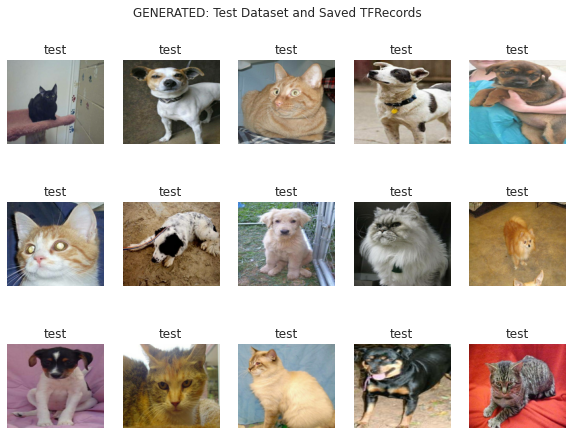

In [30]:
image_batch, *_ = next(iter(test_dataset.batch(16).take(1)))
show_tfrecord_batch(image_batch.numpy(), decode=True)
plt.suptitle("GENERATED: Test Dataset and Saved TFRecords", y=.93);

### Write dataset to TFRecord files

In [31]:
def configure_for_performance(ds):
    shuffle_buffer_size = 1024  # 1024
    batch_size          = BATCH_SIZE
    AUTOTUNE            = tf.data.AUTOTUNE
    # ds = ds.cache()
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.batch(batch_size)      
    # ds = ds.repeat()  # infinite generator
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [113]:
# Three types of data can be stored in TFRecords: bytestrings, integers and floats
# They are always stored as lists, a single data element will be a list of size 1
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.
CLASS_NAMES = CLASS_NAMES
batch_size  = BATCH_SIZE

def _bytestring_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


  
# input data in img_bytes, label, size
def to_tfrecord(tfrec_filewriter, img_bytes, label, size):  
    class_name    = CLASS_NAMES[label].encode()     # 'cat' => 0 (order defined in CLASS_NAMES)
    one_hot_class = np.eye(len(CLASS_NAMES))[label] # [1, 0] for class #0, cat
    
    feature = {
        "image": _bytestring_feature([img_bytes]),  # one image in the list
        "label": _int64_feature([label]),           # one class in the list

        # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
        "class"        : _bytestring_feature([class_name]),       # fixed length (1) list of strings, the text label
        "one_hot_class": _float_feature(one_hot_class.tolist()),  # variable length  list of floats, n=len(CLASSES)
        "size"         : _int64_feature(size.tolist()),           # [height, width] list of ints
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))


  
print("Writing TFRecords")
train_epoch_size = int(np.ceil(total_train_file / batch_size))
ds = configure_for_performance(train_dataset)

GCS_OUTPUT       = f"./CatsDogs-Images/tfrecords-jpeg-350x400-{train_epoch_size}/"  # prefix for output file names
try:
    import os
    os.makedirs(GCS_OUTPUT, exist_ok=True)
except OSError as error:
    print(error)     

for shard, (image, label, size) in enumerate(ds.take(train_epoch_size)):
    # batch size used as shard size here
    shard_size = image.numpy().shape[0]
    # good practice to have the number of records in the filename
    filename = GCS_OUTPUT+"CatsDogs-{:02d}-{}.tfrecord".format(shard, shard_size)
  
    with tf.io.TFRecordWriter(filename) as out_file:
        for i in range(shard_size):
            example = to_tfrecord(
                out_file,
                image.numpy()[i], # re-compressed image: already a byte string
                label.numpy()[i],
                size.numpy()[i],
            )
            out_file.write(example.SerializeToString())
    print("Wrote file {} containing {} records".format(filename, shard_size))

print(train_epoch_size, "TFRecords")

Writing TFRecords
Wrote file ./CatsDogs-Images/tfrecords-jpeg-350x400-137/CatsDogs-00-128.tfrecord containing 128 records
Wrote file ./CatsDogs-Images/tfrecords-jpeg-350x400-137/CatsDogs-01-128.tfrecord containing 128 records
Wrote file ./CatsDogs-Images/tfrecords-jpeg-350x400-137/CatsDogs-02-128.tfrecord containing 128 records
Wrote file ./CatsDogs-Images/tfrecords-jpeg-350x400-137/CatsDogs-03-128.tfrecord containing 128 records
Wrote file ./CatsDogs-Images/tfrecords-jpeg-350x400-137/CatsDogs-04-128.tfrecord containing 128 records
Wrote file ./CatsDogs-Images/tfrecords-jpeg-350x400-137/CatsDogs-05-128.tfrecord containing 128 records
Wrote file ./CatsDogs-Images/tfrecords-jpeg-350x400-137/CatsDogs-06-128.tfrecord containing 128 records
Wrote file ./CatsDogs-Images/tfrecords-jpeg-350x400-137/CatsDogs-07-128.tfrecord containing 128 records
Wrote file ./CatsDogs-Images/tfrecords-jpeg-350x400-137/CatsDogs-08-128.tfrecord containing 128 records
Wrote file ./CatsDogs-Images/tfrecords-jpeg-35

### Reading a TFRecord file

In [32]:
train_epoch_size = int(np.ceil(total_train_file / BATCH_SIZE))
GCS_OUTPUT       = f"./CatsDogs-Images/tfrecords-jpeg-350x400-{train_epoch_size}/"
sorted(tf.io.gfile.glob(f"{GCS_OUTPUT}CatsDogs-0*.tfrecord"))

['./CatsDogs-Images/tfrecords-jpeg-350x400-137/CatsDogs-00-128.tfrecord',
 './CatsDogs-Images/tfrecords-jpeg-350x400-137/CatsDogs-01-128.tfrecord',
 './CatsDogs-Images/tfrecords-jpeg-350x400-137/CatsDogs-02-128.tfrecord',
 './CatsDogs-Images/tfrecords-jpeg-350x400-137/CatsDogs-03-128.tfrecord',
 './CatsDogs-Images/tfrecords-jpeg-350x400-137/CatsDogs-04-128.tfrecord',
 './CatsDogs-Images/tfrecords-jpeg-350x400-137/CatsDogs-05-128.tfrecord',
 './CatsDogs-Images/tfrecords-jpeg-350x400-137/CatsDogs-06-128.tfrecord',
 './CatsDogs-Images/tfrecords-jpeg-350x400-137/CatsDogs-07-128.tfrecord',
 './CatsDogs-Images/tfrecords-jpeg-350x400-137/CatsDogs-08-128.tfrecord',
 './CatsDogs-Images/tfrecords-jpeg-350x400-137/CatsDogs-09-128.tfrecord']

In [33]:
# TFRecord file paths
TFRECORDS_FILE_PATHS = sorted(tf.io.gfile.glob(f"{GCS_OUTPUT}*.tfrecord"))
print(f'Found {len(TFRECORDS_FILE_PATHS)} TFRecords')

Found 137 TFRecords


In [34]:
# Function to decode the TFRecords
def read_tfrecord(data):
    # Read all TFRecord file paths
    TFRECORDS_FILE_PATHS = sorted(tf.io.gfile.glob(f"{GCS_OUTPUT}*.tfrecord"))
    size = IMAGE_SHAPE[:2] 
    
    # Create a description of the features.
    feature_description  = {
        "image": tf.io.FixedLenFeature((), tf.string),   # tf.string = bytestring (not text string)
        "label": tf.io.FixedLenFeature((), tf.int64),    # shape [] means scalar
        
        # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
        "class":         tf.io.FixedLenFeature((), tf.string),   # one bytestring ,param: default_value='')
        "one_hot_class": tf.io.VarLenFeature(tf.float32),        # a certain number of floats
        "size":          tf.io.FixedLenFeature((2), tf.int64),   # list of N ints
    }
    # decode the TFRecord
    tf_record = tf.io.parse_single_example(data, feature_description)
    
    # Typical code for decoding compressed images
    image = tf.io.decode_jpeg(tf_record['image'], channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.reshape(image, [*size, 3])
    
    label  = tf_record['label']  
    one_hot_class = tf.sparse.to_dense(tf_record['one_hot_class'])
    class_name = tf_record['class']
    
    # FixedLenFeature fields are now ready to use: tf_record['size']
    # VarLenFeature fields require additional sparse_to_dense decoding
    # height = tf_record['size'][0]
    # width  = tf_record['size'][1] 
    size = tf_record['size']
    
    return image, label, one_hot_class, class_name, size

# initialize TFRecord dataset
raw_dataset = tf.data.TFRecordDataset(TFRECORDS_FILE_PATHS, num_parallel_reads=tf.data.AUTOTUNE)
raw_dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [35]:
# read from TFRecords. For optimal performance, read from multiple
# TFRecord files at once and set the option experimental_deterministic = False
# to allow order-altering optimizations.
option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False

# Decode samples a tf.data.TFRecordDataset with decode function
parsed_dataset = raw_dataset.map(read_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
parsed_dataset = parsed_dataset.with_options(option_no_order)

# now a dataset of single quins (image, label, one_hot_class, class_num, size)
print(parsed_dataset)

<_OptionsDataset element_spec=(TensorSpec(shape=(350, 400, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(2,), dtype=tf.int64, name=None))>


In [36]:
train_dataset  = parsed_dataset.map(lambda image, label, one_hot_class, class_name, size: (image, label))

val_dataset    = dataset_pipeline_TFRecord(val_path, convert_TFRecord=False)
test_dataset   = dataset_pipeline_TFRecord(test_path, convert_TFRecord=False, as_labeled=False)

train_dataset, val_dataset, test_dataset

(<MapDataset element_spec=(TensorSpec(shape=(350, 400, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <ParallelMapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <ParallelMapDataset element_spec=TensorSpec(shape=<unknown>, dtype=tf.float32, name=None)>)

In [37]:
train_dataset.element_spec

(TensorSpec(shape=(350, 400, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

### batch_size and steps_per_epoch

In [38]:
BATCH_SIZE          = 64

def configure_for_performance(ds):
    shuffle_buffer_size = 1024  # 1024
    batch_size          = BATCH_SIZE
    AUTOTUNE            = tf.data.AUTOTUNE
    # ds = ds.cache()
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.batch(batch_size)      
    # ds = ds.repeat()  # infinite generator
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [39]:
# find steps_per_epoch
np.ceil(total_train_file / BATCH_SIZE), np.ceil(total_val_file / BATCH_SIZE), np.ceil(total_test_file / BATCH_SIZE), 

(274.0, 36.0, 108.0)

In [40]:
np.ceil(total_train_file / BATCH_SIZE)*BATCH_SIZE, np.ceil(total_val_file / BATCH_SIZE)*BATCH_SIZE, np.ceil(total_test_file / BATCH_SIZE)*BATCH_SIZE, 

(17536.0, 2304.0, 6912.0)

### Dataset Define image and label

In [41]:
train_ds = train_dataset.map(lambda x, y: (x, y))
val_ds   = val_dataset.map(  lambda x, y: (x, y))
test_ds  = test_dataset.map( lambda    x: x)

train_ds  = configure_for_performance(train_ds)
val_ds    = configure_for_performance(val_ds)
test_ds   = configure_for_performance(test_ds)

print(train_ds.element_spec, val_ds.element_spec, test_ds.element_spec, sep='\n')

(TensorSpec(shape=(None, 350, 400, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
TensorSpec(shape=<unknown>, dtype=tf.float32, name=None)


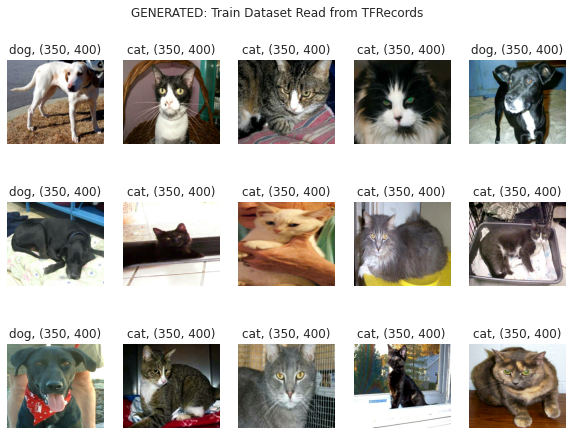

In [42]:
def show_tfrecord_batch(image_batch, label_batch=None, decode=False):
    """
    Check before saving permanently.
    """
    plt.figure(figsize=(10,10))
    for n in range(15):
        ax = plt.subplot(4, 5, n+1)        
        image = tf.io.decode_jpeg(image_batch[n], channels=3) if decode else image_batch[n]
        plt.imshow(image)
        if label_batch is None:
            plt.title(f"test")
        else:                       
            plt.title(f"{CLASS_NAMES[label_batch[n]]}, {image.shape[:2]}")
        plt.axis('off')

image_batch, label_batch = next(iter(train_ds))
show_tfrecord_batch(image_batch.numpy(), label_batch.numpy())
plt.suptitle("GENERATED: Train Dataset Read from TFRecords", y=.93);

In [43]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label      : ", np.unique(label, return_counts=True))
    # print("Label      : ", np.unique(np.argmax(label, axis=1), return_counts=True))

SAMPLE_TRAIN_LABEL = np.array(label)
print(SAMPLE_TRAIN_LABEL)

Image shape:  (64, 350, 400, 3)
Label      :  (array([0, 1]), array([43, 21]))
[1 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0 0 1 1 0]


In [44]:
for image, label in val_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label      : ", np.unique(label, return_counts=True))
    # print("Label      : ", np.unique(np.argmax(label, axis=1), return_counts=True))

print(label)

Image shape:  (64, 350, 400, 3)
Label      :  (array([0, 1]), array([30, 34]))
tf.Tensor(
[0 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 1 1 1 0 1 1 0 0 0
 1 0 1 0 0 0 1 1 0 1 0 0 1 1 1 0 0 0 1 1 0 1 0 1 1 1 0], shape=(64,), dtype=int64)


In [45]:
from collections import Counter

counter = Counter(SAMPLE_TRAIN_LABEL)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}  
class_weights

{1: 2.0476190476190474, 0: 1.0}

In [46]:
from sklearn.utils import class_weight

class_weights = dict(
    zip(np.unique(SAMPLE_TRAIN_LABEL),
        class_weight.compute_class_weight(
            class_weight = 'balanced',
            classes = np.unique(SAMPLE_TRAIN_LABEL), 
            y = SAMPLE_TRAIN_LABEL)
))
print(class_weights)

{0: 0.7441860465116279, 1: 1.5238095238095237}


In [47]:
from sklearn.utils import class_weight
sample_weight = class_weight.compute_sample_weight(class_weight='balanced', y=SAMPLE_TRAIN_LABEL)
np.unique(sample_weight)

array([0.74418605, 1.52380952])

### Dataset Shard Policy for kaggle GPU Warning

In [48]:
if gpus: 
    # Kaggle Warning -> Shard Policy for GPU
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.FILE
    
    train_ds = train_ds.with_options(options)
    val_ds   = val_ds.with_options(options)
    test_ds  = test_ds.with_options(options)
    print('Apply Shard Policy for GPU')
else:
    print('Passed')

Passed


# Build the Model with Image FROM TFRecords

In [49]:
print("Model Defined Shape: ", IMAGE_SHAPE)        # Input Layer Shape

# way-1
def build_classifier_model(
        input_shape: int = IMAGE_SHAPE,
        units:int        = 64,
) -> tf.keras.models.Model:    
    import tensorflow as tf    
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=input_shape))
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_uniform', padding='same', activation='relu'))    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_uniform', activation='relu'))  
    model.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2,2)))   
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Conv2D(filters=units, kernel_size=(3,3), kernel_initializer='he_uniform', activation='relu')) 
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))    
    model.add(tf.keras.layers.BatchNormalization())  
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Flatten())    
    model.add(tf.keras.layers.Dense(units, activation='relu'))  
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(32, activation='relu'))   
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    precision_at_recall = tf.keras.metrics.PrecisionAtRecall(recall=0.8)
    f1_score            = tfa.metrics.F1Score(num_classes=2, threshold=0.5)
    fbeta_score         = tfa.metrics.FBetaScore(2, beta=2.0, reduction="mean")

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss = 'binary_crossentropy',  # 'categorical_crossentropy', 
                  metrics = ['binary_accuracy', 'Recall', ], 
                  # weighted_metrics = [tf.keras.metrics.Recall()] 
                  )
    return model

Model Defined Shape:  (350, 400, 3)


In [50]:
from sklearn.pipeline import Pipeline

tf.keras.backend.clear_session()

with strategy.scope():  
    model = build_classifier_model()
    display(model.summary())

    pipe_cnn1 = Pipeline([
        ("cnn", model)
    ])
    pipe_cnn1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 350, 400, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 350, 400, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 175, 200, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 175, 200, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 173, 198, 32)      9248      
                                                                 
 average_pooling2d (AverageP  (None, 86, 99, 32)       0

None

In [51]:
early_stop = EarlyStopping(monitor='val_recall', mode="max",
                           verbose = 1, patience = 9, restore_best_weights = True)

In [52]:
# We will reduce the learning rate when then monitor not increase or decrease for 2 steps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', mode="min",
                                            verbose=1, patience=2, factor=0.5, min_lr=1e-10)

In [96]:
%%time
# history = pipe_cnn1.fit(train_data_gen, cnn__validation_data = val_data_gen, cnn__validation_steps=len(val_data_gen), #cnn__validation_split = 0.1, cnn__batch_size = 16, 
#                     cnn__epochs = 1000, cnn__steps_per_epoch=len(train_data_gen), cnn__verbose = 1, cnn__callbacks=[early_stop], cnn__class_weight=class_weights) # 

history = pipe_cnn1.fit(train_ds, cnn__validation_data = val_ds, cnn__validation_steps=np.ceil(total_val_file / BATCH_SIZE),  
                    cnn__epochs = 100, cnn__steps_per_epoch=np.ceil(total_train_file / BATCH_SIZE), cnn__verbose = 1, cnn__callbacks=[early_stop, learning_rate_reduction])  

Epoch 1/100
274/274 [==============================] - 125s 447ms/step - loss: 0.8478 - binary_accuracy: 0.7058 - recall: 0.3191 - val_loss: 3.4612 - val_binary_accuracy: 0.5323 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/100
274/274 [==============================] - 117s 426ms/step - loss: 0.4734 - binary_accuracy: 0.7835 - recall: 0.4190 - val_loss: 1.5920 - val_binary_accuracy: 0.5415 - val_recall: 0.0196 - lr: 0.0010
Epoch 3/100
274/274 [==============================] - 117s 427ms/step - loss: 0.3945 - binary_accuracy: 0.8282 - recall: 0.5768 - val_loss: 0.9160 - val_binary_accuracy: 0.6341 - val_recall: 0.2334 - lr: 0.0010
Epoch 4/100
274/274 [==============================] - 117s 428ms/step - loss: 0.3173 - binary_accuracy: 0.8651 - recall: 0.6944 - val_loss: 1.0213 - val_binary_accuracy: 0.6672 - val_recall: 0.3091 - lr: 0.0010
Epoch 5/100
274/274 [==============================] - ETA: 0s - loss: 0.2487 - binary_accuracy: 0.8980 - recall: 0.7797
Epoch 5: ReduceLROnPlateau 

In [43]:
# save model permanently and check
# model.save_weights('first_try.h5')
pipe_cnn1[-1].save('./content/drive/MyDrive/cat_dog_data1.h5')

In [98]:
history[-1].metrics_names

['loss', 'binary_accuracy', 'recall']

In [99]:
history_df = pd.DataFrame(history[-1].history.history)
history_df.index += 1
history_df.tail(10)

,loss,binary_accuracy,recall,val_loss,val_binary_accuracy,val_recall,lr
6,0.1487,0.9419,0.8764,0.6981,0.7585,0.6088,0.0005
7,0.1067,0.9601,0.9168,0.9715,0.7454,0.5434,0.0005
8,0.0747,0.9726,0.9447,1.3065,0.7140,0.4491,0.0005
9,0.0501,0.9832,0.9678,1.4547,0.7096,0.4258,0.0003
10,0.0378,0.9877,0.9773,1.4557,0.7293,0.4706,0.0003
11,0.0277,0.9917,0.9825,1.3376,0.7467,0.5257,0.0001
12,0.0255,0.9917,0.9839,1.4358,0.7389,0.5061,0.0001
13,0.0224,0.9922,0.9857,1.3992,0.7459,0.5145,0.0001
14,0.0196,0.9938,0.9877,1.5200,0.7419,0.5079,0.0001
15,0.0202,0.9946,0.9897,1.5377,0.7406,0.5042,0.0000


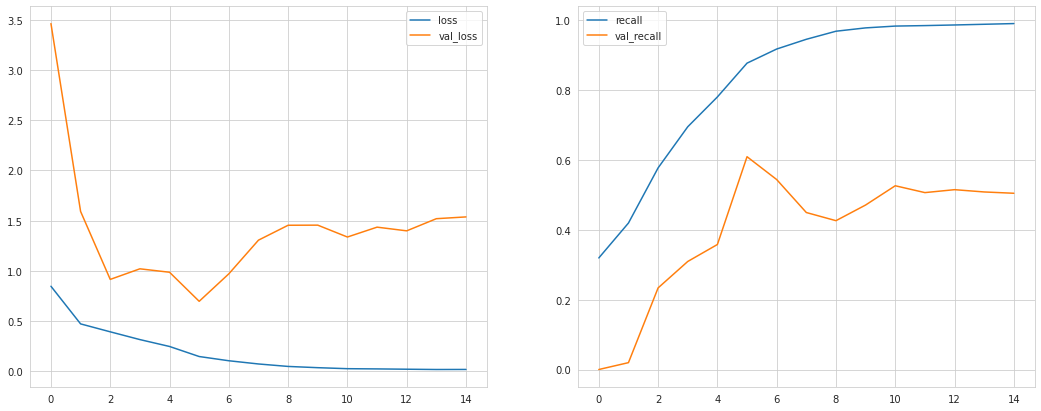

In [104]:
# Plot training results
plot_history(history, pipe=True)

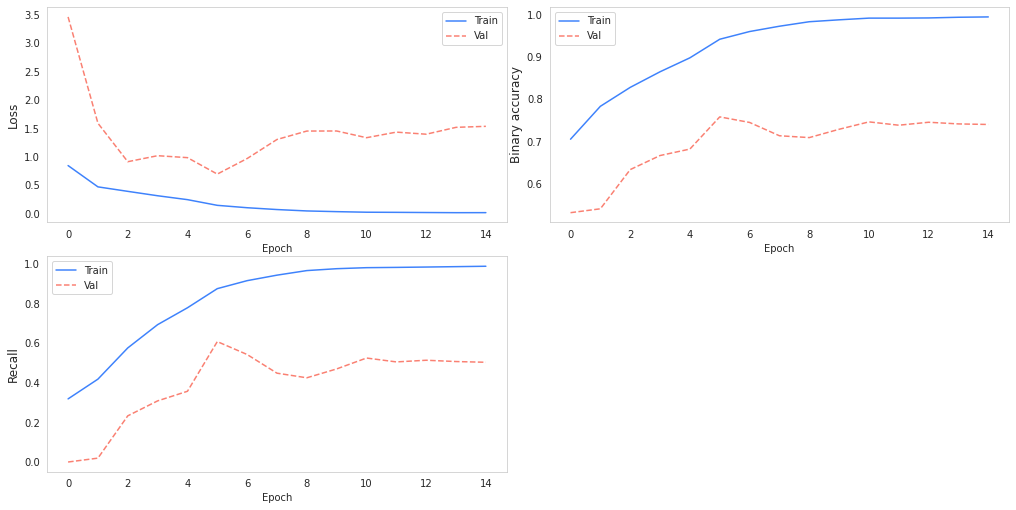

In [105]:
plot_metrics(pipe_cnn1, pipe_cnn1[-1].metrics_names, pipe=True)

### Test Data Precision and Accuracy Label

In [53]:
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score, roc_curve #, plot_roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import  SCORERS, precision_score, recall_score, f1_score, accuracy_score, cohen_kappa_score

In [54]:
model = tf.keras.models.load_model('./content/drive/MyDrive/cat_dog_data1.h5')

In [57]:
def get_label_and_pred(ds, steps):
    y_val =  y_pred_prob = None
    for step in range(int(steps)):
        X_val_, y_val_ = next(iter(ds)) 
        y_pred_prob_ = model.predict(X_val_, verbose=0)

        if y_val is None:          
            y_val       =  y_val_ 
            y_pred_prob = y_pred_prob_ 

        y_val       = np.hstack((y_val, y_val_)) 
        y_pred_prob = np.vstack((y_pred_prob, y_pred_prob_)) 

    return y_val, y_pred_prob 

In [58]:
%%time
# predict probabilities
y_val, y_pred_prob_val     = get_label_and_pred(val_ds, 15)
y_train, y_pred_prob_train = get_label_and_pred(train_ds, 15)

CPU times: user 7min 37s, sys: 40.8 s, total: 8min 18s
Wall time: 5min 20s


In [61]:
# predict crisp classes 
y_pred_val   = y_pred_prob_val >= 0.5 
y_pred_train = y_pred_prob_train >= 0.5 

y_pred_val.shape, y_pred_train.shape

((1024, 1), (1024, 1))

In [64]:
print('TEST')    
print(confusion_matrix(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))
print("-------------------------------------------------------")
print('TRAIN')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

TEST
[[474  55]
 [175 320]]
              precision    recall  f1-score   support

           0       0.73      0.90      0.80       529
           1       0.85      0.65      0.74       495

    accuracy                           0.78      1024
   macro avg       0.79      0.77      0.77      1024
weighted avg       0.79      0.78      0.77      1024

-------------------------------------------------------
TRAIN
[[711  23]
 [ 20 270]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       734
           1       0.92      0.93      0.93       290

    accuracy                           0.96      1024
   macro avg       0.95      0.95      0.95      1024
weighted avg       0.96      0.96      0.96      1024



In [65]:
(y_val != y_pred_val).sum()

519630

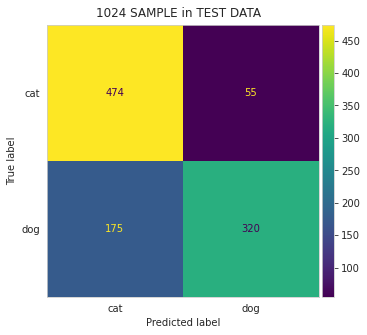

In [73]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(
    y_val, y_pred_val,
    # labels=classes
)

cmp = ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=CLASS_NAMES
)

fig, ax = plt.subplots(figsize=(5, 5))

# Deactivate default colorbar
cmp.plot(ax=ax, colorbar=False)
plt.grid(False)

# Adding custom colorbar
cax = fig.add_axes([ax.get_position().x1+.01, ax.get_position().y0, .033, ax.get_position().height])
plt.colorbar(cmp.im_, cax=cax)
plt.suptitle("1024 SAMPLE in TEST DATA", y=.93);

In [74]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_val, y_pred_val)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_val, y_pred_val, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_val, y_pred_val, average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, y_pred_val, average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.775391
Precision: 0.789802
Recall: 0.775391
F1 score: 0.771341


In [75]:
# kappa
kappa = cohen_kappa_score(y_val, y_pred_val)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_val, y_pred_prob_val[:, 0])
print('ROC AUC: %f' % auc)
auc = roc_auc_score(y_val, y_pred_prob_val)
print('ROC AUC: %f' % auc)

Cohens kappa: 0.546754
ROC AUC: 0.866388
ROC AUC: 0.866388


# Prediction

In [76]:
# View a random image
import random

In [78]:
model = tf.keras.models.load_model('./content/drive/MyDrive/cat_dog_data1.h5')

In [79]:
random_image = random.sample(test_file_paths, 1)
random_image

['./data/test/3979.jpg']

In [80]:
# image_path = 'cat-dog.jpg'
image_path = random_image[0]
image_path

'./data/test/3979.jpg'

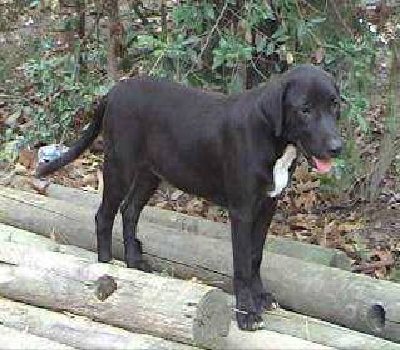

In [81]:
my_image = tf.keras.preprocessing.image.load_img(image_path, target_size=IMAGE_SHAPE)
my_image

In [82]:
my_image = tf.keras.preprocessing.image.img_to_array(my_image)
my_image.shape

(350, 400, 3)

In [83]:
my_image = np.expand_dims(my_image, axis=0)
my_image.shape

(1, 350, 400, 3)

In [85]:
model.predict(my_image)

1/1 [==============================] - 0s 153ms/step


array([[1.]], dtype=float32)

### Predict Test Data

In [87]:
y_pred_prob_test = model.predict(test_ds)
y_pred_prob_test.shape

108/108 [==============================] - 501s 4s/step


(6897, 1)

In [88]:
# predict crisp classes 
y_pred_test = y_pred_prob_test >= 0.5 

In [91]:
print("Label      : ", np.unique(y_pred_test*1, return_counts=True))

Label      :  (array([0, 1]), array([4423, 2474]))


In [92]:
CLASS_NAMES

array(['cat', 'dog'], dtype='<U3')

# End of the Project